In [98]:
import geopandas
import pytz
from datetime import datetime
import os
import shutil
import wget
import cartopy.crs as ccrs
from datetime import timedelta
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
import numpy as np

In [86]:

lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                 central_latitude=38.5,
                                 standard_parallels=(38.5, 38.5),
                                 globe=ccrs.Globe(semimajor_axis=6371229,
                                                  semiminor_axis=6371229))

In [87]:
def get_frp_fn_url(dt):
    tt = dt.timetuple()
    month = str(tt.tm_mon).zfill(2)
    day = str(tt.tm_mday).zfill(2)
    yr = str(tt.tm_year)
    fn = 'hms_fire{}{}{}.zip'.format(yr, month, day)
    url = 'https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Fire_Points/Shapefile/{}/{}/{}'.format(yr, month, fn)
    return fn, url

In [88]:
def get_frp(dt, frp_dir):
    fn, url = get_frp_fn_url(dt)
    frp_shape_fn = frp_dir + fn
    print(frp_shape_fn)
    if os.path.exists(frp_shape_fn):
        print("{} already exists".format(fn))
    else:
        print('DOWNLOADING frp: {}'.format(fn))
        filename = wget.download(url, out=frp_dir)
        shutil.unpack_archive(filename, frp_dir)
    frp = geopandas.read_file(frp_shape_fn)
    return frp


In [89]:
dt_str = '2023/04/04 14:50'
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M'))
print(dt)
fire = get_frp(dt, "/home/rey/projects/GOES_FRP/frp_shapefiles/")
print(fire)
fire = fire.to_crs(lcc_proj)

2023-04-04 14:50:00+00:00
/home/rey/projects/GOES_FRP/frp_shapefiles/hms_fire20230404.zip
hms_fire20230404.zip already exists
             Lon        Lat  YearDay  Time  Satellite Method  Ecosystem  \
0     -66.744949  18.077087  2023094  0506    NOAA 20  VIIRS         93   
1     -68.066635  46.766396  2023094  0552  SUOMI NPP  VIIRS         30   
2     -77.398834  26.739498  2023094  0558  SUOMI NPP  VIIRS         93   
3     -77.392616  26.739120  2023094  0558  SUOMI NPP  VIIRS         93   
4     -79.201447  21.899944  2023094  0558  SUOMI NPP  VIIRS         41   
...          ...        ...      ...   ...        ...    ...        ...   
47270 -90.152489  19.113523  2023095  0556  GOES-EAST    FDC         34   
47271 -90.048340  19.091976  2023095  0556  GOES-EAST    FDC         34   
47272 -84.134743  15.025342  2023095  0556  GOES-EAST    FDC         22   
47273 -80.857155  22.808207  2023095  0556  GOES-EAST    FDC         93   
47274 -71.020760  18.985132  2023095  0556  GOES-

In [90]:
def get_image_bounds(x, y, res=256, img_size=1000):
    dist = int(img_size/2*res)
    x_min = x - dist
    x_max = x + dist
    y_min = y - dist
    y_max = y + dist
    return x_min, x_max, y_min, y_max

def get_relevant_fire_pts(fire, fire_pt_oi, img_size=256, res=1000):
    #relevant indices within fire shapefile
    print(fire_pt)
    dt_oi = get_dt_from_fire_pt(fire_pt_oi)
    x_oi = fire_pt_oi.geometry.x
    y_oi = fire_pt_oi.geometry.y
    rel_idx = []
    x_min, x_max, y_min, y_max = get_image_bounds(x_oi, y_oi, res, img_size)
    for idx, row in fire.iterrows():
        dt = get_dt_from_fire_pt(row)
        x = row.geometry.x
        y = row.geometry.y
        # if within bounds of GOES data input and time
        if x_min < x and x_max > x and y_min < y and y_max > y and abs(dt_oi - dt) < timedelta(minutes=10):
            rel_idx.append(idx)
    rel_fire = fire.iloc[rel_idx]
    return rel_fire
    


In [91]:
def get_dt_from_fire_pt(fire_pt):
    yr_dn_utc = '{}{}'.format(fire_pt['YearDay'], fire_pt['Time'])
    return pytz.utc.localize(datetime.strptime(yr_dn_utc, '%Y%j%H%M'))
fire_head = fire.head(5)
fire_pt_oi = fire.iloc[2]
dt = get_dt_from_fire_pt(fire_pt_oi)
rel_fire = get_relevant_fire_pts(fire_head, fire_pt_oi)    
#print(fire_pt_oi)

Lon                                            -66.744949
Lat                                             18.077087
YearDay                                           2023094
Time                                                 0506
Satellite                                         NOAA 20
Method                                              VIIRS
Ecosystem                                              93
FRP                                                 2.219
geometry     POINT (3386999.994924295 -1746293.490533073)
Name: 0, dtype: object


In [92]:
rel_fire

,Lon,Lat,YearDay,Time,Satellite,Method,Ecosystem,FRP,geometry
2,-77.398834,26.739498,2023094,0558,SUOMI NPP,VIIRS,93,1.732,POINT (2020714.909 -1095143.375)
3,-77.392616,26.739120,2023094,0558,SUOMI NPP,VIIRS,93,1.379,POINT (2021339.309 -1095048.708)


<PIL.Image.Image image mode=1 size=256x256 at 0x7FAA8EB78090>


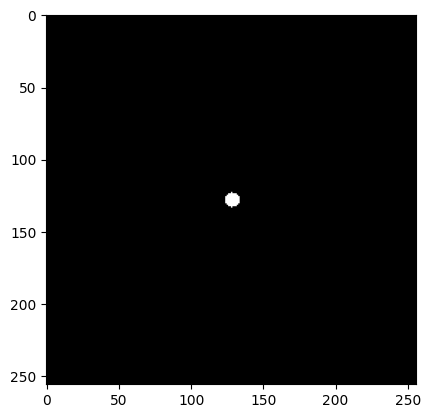

In [109]:
def plot_label(fire_pt_oi, rel_fire, img_shape=256):
    x_oi = fire_pt_oi.geometry.x
    y_oi = fire_pt_oi.geometry.y
    x_min, x_max, y_min, y_max = get_image_bounds(x_oi, y_oi)
    fig = plt.figure(figsize=(img_shape/100, img_shape/100), dpi=100)
    ax = fig.add_subplot(1, 1, 1, projection=lcc_proj)
    rel_fire.plot(ax=ax, facecolor='black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis('off')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    png_fn = 'temp.png'
    plt.savefig(png_fn, dpi=100)
    plt.close(fig)
    img = Image.open(png_fn)
    bw = img.convert('1')
    bw = ImageOps.invert(bw)
    plt.imshow(bw)
    #plt.show(bw)
    print(bw)
    truth = np.asarray(bw).astype('i')
    #os.remove(png_fn)
    
plot_label(fire_pt_oi, rel_fire)

In [25]:
dt = get_dt_from_fire_pt(fire.iloc[0])
dt2 = get_dt_from_fire_pt(fire.iloc[1])


In [27]:
abs(dt-dt2)


datetime.timedelta(seconds=2760)

In [34]:
fire_pt_oi

Lon                                            -66.744949
Lat                                             18.077087
YearDay                                           2023094
Time                                                 0506
Satellite                                         NOAA 20
Method                                              VIIRS
Ecosystem                                              93
FRP                                                 2.219
geometry     POINT (3386999.994924295 -1746293.490533073)
Name: 0, dtype: object

In [36]:
fire_pt_oi.geometry.x

3386999.994924295